# Theory

In [1]:
import numpy as np

from scipy.optimize import minimize

import matplotlib.pyplot as plt
import seaborn
seaborn.set_style("darkgrid")

from src.callback import Simulator

# Maximum Likelihood Estimation in one dimension

## Generating a sample

The probability density function of the univariate Gaussian is given by:

$$f(x | \mu, \sigma^{2}) = \frac{1}{\sqrt{2\pi \sigma^{2}}}e^{-\frac{1}{2\sigma^{2}}(x - \mu)^{2}}$$

[-4.   -3.99 -3.98 ...  9.97  9.98  9.99]
Shape: (500,)


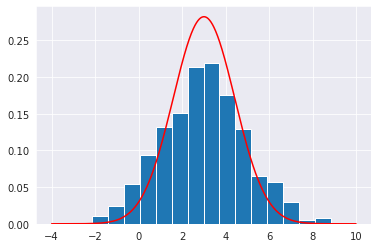

In [2]:
# set the random seed
rng = np.random.default_rng(42)
# generate a sample of normally distributed random variables with mean mu and variance var
mu = 3
var = 2
# generate a random sample using the numpy function
sample = rng.normal(mu, var, 500)

def pdf(x, mu, var):
    """
        Return a vector (shape of x) of the probabilities
        of the values of x
    """
    return 1 / (np.sqrt(2*np.pi*var)) * np.exp(-1/(2*var)*(x - mu)**2)

xx = np.arange(-4, 10, 0.01)

print(xx)
probs = pdf(xx, mu, var)

print(f"Shape: {sample.shape}")

plt.hist(sample, bins=15, density=True);
plt.plot(xx, probs, c='red')

## Maximum Likelihood Estimation

Here we minimise the likelihood function for the univariate Gaussian pdf. This allows us to find the best-fitting parameters.

The log-likelihood of the univariate Gaussian is given by:

$$\log \mathcal{L}(\mu, \sigma^{2}| \vec{x}) = -\frac{n}{2} \log (2\pi) - \frac{n}{2} \log \sigma^{2} - \frac{1}{2\sigma^{2}}\sum_{i = 1}^{n} (x_{i} - \mu)^{2}$$

and hence we want to minimise

$$\hat{\mu} = -\text{argmin}_{\mu} \log \mathcal{L}(\mu, \sigma^{2} | \vec{x})$$

In [3]:
# define the univariate Gaussian likelihood function
def likelihood(params, x):
    mu = params
    sigma = 2
    n = len(x)
    L = (n/2)*np.log(2*np.pi)+(n/2)*np.log(sigma**2)+(1/(2*sigma**2))*sum((x-mu)**2)
    return L

## Evaluating the likelihood function

Evaluating the likelihood function over a range of values, we can geometrically approximate the MLE to be zero.

Text(0.5, 0, 'Mean value: $\\mu$')

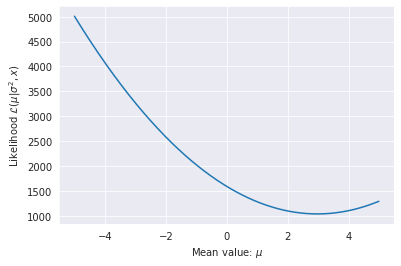

In [4]:
# range of mu values to test for maximum likelihood
mu = np.arange(-5, 5, 0.01)
# list for storing the likelihood values for each mu value
likelihood_values = []

# loop through all values of mu and append the likelihood value output to likelihood_values
for val in mu:
    likelihood_values.append(likelihood(val, sample))
     
# plot the likelihood values
plt.plot(mu, likelihood_values)
plt.ylabel("Likelihood $\mathcal{L}(\mu | \sigma^{2}, x)$")
plt.xlabel("Mean value: $\mu$")

## Minimising the likelihood function using scipy.optimize.minimize

Choose -4 as our initial guess for $\mu$.

As we can see in the plot above, $\text{MLE}_{\mu} \approx 3$, so we should see a clear path from left to right across the curve.

In [5]:
# choose initial guess to be -4
initial_guess = -4

# instantiate the simulator class
lik_sim = Simulator(likelihood)

# minimise the -log(L) function using the wrapper class Simulator
lik_model = minimize(lik_sim.simulate, x0=initial_guess,
                     args=(sample),
                     method="Nelder-Mead",
                     tol=1e-6,
                     options={"disp": True})

lik_model.x

Optimization terminated successfully.
         Current function value: 1035.950498
         Iterations: 27
         Function evaluations: 54


array([2.97374802])

In [6]:
callback = lik_sim.to_dataframe()
callback

,parameter,likelihood,iteration
0,-4.000000,4075.522809,1
1,-3.800000,3903.679117,2
2,-3.600000,3736.835424,3
3,-3.200000,3418.148039,4
4,-2.800000,3119.460654,5
5,-2.000000,2582.085884,6
6,-1.200000,2124.711114,7
7,0.400000,1449.961575,8
8,2.000000,1095.212035,9
9,3.600000,1060.462495,10


Text(0.5, 0, 'Mean value: $\\mu$')

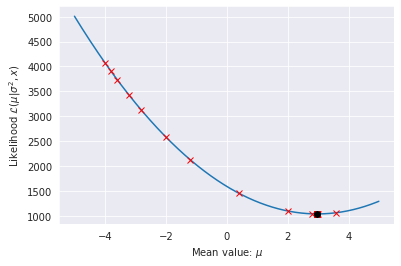

In [7]:
mu = np.arange(-5, 5, 0.01)
likelihood_values = []

for val in mu:
    likelihood_values.append(likelihood(val, sample))
     
plt.plot(mu, likelihood_values)
plt.plot(callback.parameter, callback.likelihood, 'rx')
plt.plot(lik_model.x, lik_model.fun, 'ko')

plt.ylabel("Likelihood $\mathcal{L}(\mu | \sigma^{2}, x)$")
plt.xlabel("Mean value: $\mu$")

## Setting $\mu$ to be a function of some parameters $a$, $b$

Let $\mu(a, b) = ax^{2} + bx^{2}$

In [8]:
def model(params, x):
    x, y = params
    return ((x + 2*y - 7)**2 + (2*x + y - 5)**2)

In [9]:
# define the univariate Gaussian likelihood
def likelihood(params, x):
    mu = model(params, x)
    sigma = 2
    n = len(x)
    L = (n/2)*np.log(2*np.pi)+(n/2)*np.log(sigma**2)+(1/(2*sigma**2))*sum((x-mu)**2)
    return L

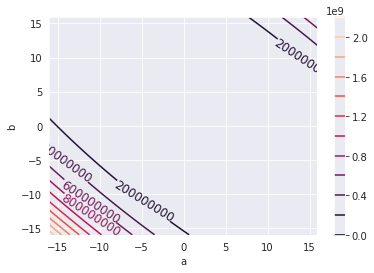

In [16]:
a = np.arange(-16, 16, .1)
b = np.arange(-16, 16, .1)

aa, bb = np.meshgrid(a, b, indexing='ij')

values = np.array((aa, bb)).T.reshape(-1, 2)

likelihood_values = np.zeros(values.shape[0])

for idx, val in enumerate(values):
    likelihood_values[idx] = likelihood(val, sample)
    
likelihood_values

contours = plt.contour(aa, bb, likelihood_values.reshape(aa.shape), 10)
plt.clabel(contours, inline=1, fontsize=12)
plt.ylabel("b")
plt.xlabel("a")
plt.colorbar()

In [17]:
initial_guess = [10, 15]

likelihood_sim = Simulator(likelihood)

lik_model = minimize(likelihood_sim.simulate, x0=initial_guess,
                     args=(sample),
                     method="Nelder-Mead",
                     tol=1e-6,
                     options={"disp": True})

Optimization terminated successfully.
         Current function value: 1035.950498
         Iterations: 80
         Function evaluations: 167


In [18]:
callback = likelihood_sim.to_dataframe()

callback

,parameter 1,parameter 2,likelihood,iteration
0,10.000000,15.000000,2.465198e+08,1
1,10.500000,14.250000,2.342785e+08,2
2,10.750000,13.500000,2.121969e+08,3
3,10.250000,13.500000,1.920835e+08,4
4,10.125000,12.750000,1.600844e+08,5
5,10.875000,11.250000,1.362851e+08,6
6,11.312500,9.375000,9.889637e+07,7
7,10.687500,8.625000,7.027973e+07,8
8,10.656250,6.187500,3.612738e+07,9
9,11.843750,2.812500,2.022692e+07,10


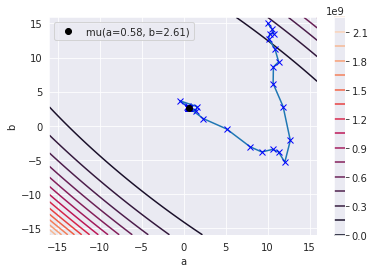

In [21]:
plt.contour(aa, bb, likelihood_values.reshape(aa.shape), 20)
plt.ylabel("b")
plt.xlabel("a")
plt.plot(callback["parameter 1"], callback["parameter 2"])
plt.plot(callback["parameter 1"], callback["parameter 2"], 'bx')
plt.plot(lik_model.x[0], lik_model.x[1], 'ko', label=f"mu(a={lik_model.x[0]:.2f}, b={lik_model.x[1]:.2f})")
plt.legend()
plt.colorbar()